In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from cwgan_gp import c_Generator, c_Discriminator, initialize_weights
from utils import gradient_penalty_conditional
from lenet import Net

import matplotlib.pyplot as plt
import time

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
classifier = Net()
classifier.to(device)
classifier.load_state_dict(torch.load('./models/lenet_mnist_model.pth'))

<All keys matched successfully>

In [4]:
# Conditional WGAN_GP hyperparameters
NUM_CLASSES = 10
GEN_EMBEDDING = 100
IMG_SIZE = 64
# Hyperparameters for WGANs + Gradient Penalty
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [14]:
# MNIST Dataset
transform=transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root= './data', train = True, download =True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = datasets.MNIST(root= './data', train = False, download =True, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [6]:
netD = c_Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
netG = c_Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)

In [7]:
netD.apply(initialize_weights)
netG.apply(initialize_weights)

c_Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

In [8]:
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [9]:
def save_checkpoint(state, cwgan_gp_path):
    print("saving_checkpoint")
    torch.save(state, cwgan_gp_path)
    
def load_checkpoint(checkpoint):
    print("loading_checkpoint")
    netG.load_state_dict(checkpoint['gen_state_dict'])
    netD.load_state_dict(checkpoint['disc_state_dict'])
    optimizerG.load_state_dict(checkpoint['gen_optimizer'])
    optimizerD.load_state_dict(checkpoint['disc_optimizer'])
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    return G_losses, D_losses

In [10]:
cwgan_gp_path = "./models/cwgan_gp_gelu_mnist.pth.tar"
load_model = True
G_losses = []
D_losses = []

In [11]:
if load_model:
    G_losses, D_losses = load_checkpoint(torch.load(cwgan_gp_path))

loading_checkpoint


In [12]:
len(G_losses), len(D_losses)

(70, 70)

In [15]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, y) in enumerate(train_loader):
        ### Create adversarial sample
        real, y = real.to(device), y.to(device)

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(real.shape[0], Z_DIM, 1, 1).to(device)
            fake = netG(noise, y)
            disc_real = netD(real, y).reshape(-1)
            disc_fake = netD(fake, y).reshape(-1)
            gp = gradient_penalty_conditional(netD, y, real, fake, device=device)
            lossD = (
                -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP*gp
            )
            netD.zero_grad()
            lossD.backward(retain_graph=True)
            optimizerD.step()
            
            # for p in netD.parameters():
            #     p.data.clamp_(-weight_clip, weight_clip)
                
        ## Train Generator: min -E[D(G(z))]
        output = netD(fake, y).reshape(-1)
        lossG = -torch.mean(output)
        netG.zero_grad()
        lossG.backward()
        optimizerG.step()

        # ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        # disc_real = netD(real).reshape(-1)
        # lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        # disc_fake = netD(fake).reshape(-1)
        # lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        # netD.zero_grad()
        # lossD = (lossD_real + lossD_fake) / 2
        # lossD.backward(retain_graph=True)
        # optimizerD.step()

        # ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # output = netD(fake).view(-1)
        # lossG = criterion(output, torch.ones_like(output))
        # netG.zero_grad()
        # lossG.backward()
        # optimizerG.step()

    G_losses.append(lossG.item())
    D_losses.append(lossD.item())
    
    if ((epoch+1)%1 == 0):
        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}, time_taken: {(time.time()-start_time)/60:.4f} mins"
        )
        checkpoint = {'gen_state_dict': netG.state_dict(), 'disc_state_dict': netD.state_dict(),
              'gen_optimizer': optimizerG.state_dict(), 'disc_optimizer': optimizerD.state_dict(),
                 'G_losses': G_losses, 'D_losses': D_losses}
        save_checkpoint(checkpoint, cwgan_gp_path)

KeyboardInterrupt: 

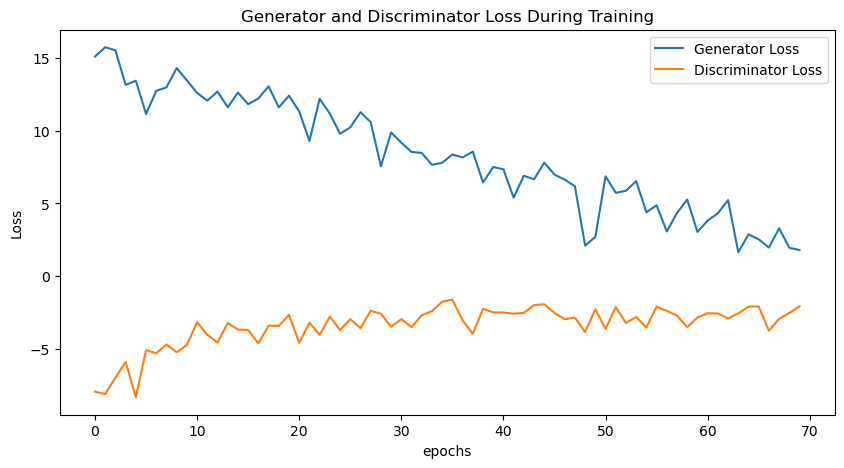

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./plots/cwgan_gp_loss_mnist.png", transparent=False, dpi=300)
plt.show()